In [1]:
import torch
import torch.nn as nn

import load_data
from load_data import NAME
from my_model import RNN, LSTM

import random
import time
import math

In [6]:
# load data
names = NAME('data/names/', '*.txt')

# create models
n_hidden = 128
n_cell = 128

rnn = RNN(NAME.n_letters, n_hidden, names.n_categories)
lstm =  LSTM(NAME.n_letters, n_cell, names.n_categories)
print(names.n_categories)

18


In [3]:
# check functions
input = names.lineToTensor('Albert')

hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

cell = torch.zeros(1, n_cell)

output, next_hidden, next_cell = lstm(input[0], hidden, cell)
print(output)

for i in range(10):
    category, line, category_tensor, line_tensor = names.randomTrainingExample()
    print('category =', category, '/ line =', line)

tensor([[-2.9990, -2.9051, -2.7556, -2.9539, -2.9623, -2.9462, -2.7803, -2.8471,
         -2.7978, -2.8571, -2.9200, -2.9242, -2.9262, -2.9040, -2.9688, -2.8413,
         -2.9653, -2.8174]], grad_fn=<LogSoftmaxBackward0>)
tensor([[-2.8799, -2.9471, -2.8690, -2.8014, -2.9535, -2.8279, -2.8331, -2.9690,
         -2.9698, -2.9583, -2.8653, -2.9599, -2.8158, -2.8272, -2.9156, -2.9763,
         -2.8647, -2.8267]], grad_fn=<LogSoftmaxBackward0>)
category = Portuguese / line = De santigo
category = Irish / line = Riain
category = French / line = Royer
category = Irish / line = Dubhshlaine
category = Scottish / line = Smith
category = Vietnamese / line = Vo
category = French / line = Belanger
category = Czech / line = Hadash
category = Dutch / line = Haenraats
category = Spanish / line = Roma


In [29]:
rnn = RNN(NAME.n_letters, n_hidden, names.n_categories)
lstm =  LSTM(NAME.n_letters, n_cell, names.n_categories)

rnn_criterion = nn.NLLLoss()
lstm_criterion = nn.NLLLoss()

def train_rnn(category_tensor, line_tensor):
    learning_rate = 0.005
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = rnn_criterion(output, category_tensor)

    # backpropagation step, calculate loss gradient about all parameter
    loss.backward()

    # parameters from rnn is weight & bias for each layer
    for p in rnn.parameters():
        # update parameter, basic gradient descent - In general, use optimizer instead of basic gd
        # add -(gradient * learning_rate) to parameter
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

def train_lstm(category_tensor, line_tensor):
    learning_rate = 0.015
    hidden = lstm.initHidden()
    cell = lstm.initCell()

    lstm.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden, cell = lstm(line_tensor[i], hidden, cell)

    loss = lstm_criterion(output, category_tensor)

    # backpropagation step, calculate loss gradient about all parameter
    loss.backward()

    # parameters from rnn is weight & bias for each layer
    for p in lstm.parameters():
        # update parameter, basic gradient descent - In general, use optimizer instead of basic gd
        # add -(gradient * learning_rate) to parameter
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

In [30]:
n_iters = 400000
# there is 100000 of iteration (too many), so print every 5000 times
print_every = 20000
# loss record term for loss plot visualization
plot_every = 4000


# loss avg within plot_every term
rnn_current_loss = 0
lstm_current_loss = 0
# loss record for loss plot visualization
rnn_all_losses = []
lstm_all_losses = []


def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s/60)
    s -= m * 60
    return '%dm %ds' % (m, s)


start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = names.randomTrainingExample()
    
    rnn_output, rnn_loss = train_rnn(category_tensor, line_tensor)
    rnn_current_loss += rnn_loss

    lstm_output, lstm_loss = train_lstm(category_tensor, line_tensor)
    lstm_current_loss += lstm_loss

    # print learning state
    if iter % print_every == 0:
        print('%d %d%% (%s)'
              % (iter, iter / n_iters * 100, timeSince(start)))
        guess, guess_i = names.categoryFromOutput(rnn_output)
        correct = 'O' if guess == category else 'X (%s)' % category
        print('[RNN] %.4f %s / %s %s'
              % (rnn_loss, line, guess, correct))
        guess, guess_i = names.categoryFromOutput(lstm_output)
        correct = 'O' if guess == category else 'X (%s)' % category
        print('[LSTM] %.4f %s / %s %s\n'
              % (lstm_loss, line, guess, correct))

    # record loss avg
    if iter % plot_every == 0:
        rnn_all_losses.append(rnn_current_loss / plot_every)
        lstm_all_losses.append(lstm_current_loss / plot_every)
        rnn_current_loss = 0
        lstm_current_loss = 0

20000 5% (1m 1s)
[RNN] 0.4525 Okakura / Japanese O
[LSTM] 1.0702 Okakura / Japanese O

40000 10% (2m 4s)
[RNN] 0.9887 Franco / Italian O
[LSTM] 1.3313 Franco / Spanish X (Italian)

60000 15% (3m 8s)
[RNN] 1.9437 Bautista / Japanese X (Spanish)
[LSTM] 1.4261 Bautista / Japanese X (Spanish)

80000 20% (4m 11s)
[RNN] 0.1015 Brunetti / Italian O
[LSTM] 0.1337 Brunetti / Italian O

100000 25% (5m 15s)
[RNN] 0.5753 Hirata / Japanese O
[LSTM] 0.0739 Hirata / Japanese O

120000 30% (6m 20s)
[RNN] 0.2504 Youn / Korean O
[LSTM] 0.0756 Youn / Korean O

140000 35% (7m 22s)
[RNN] 1.6455 Koumans / Greek X (Dutch)
[LSTM] 0.2031 Koumans / Dutch O

160000 40% (8m 24s)
[RNN] 1.8716 Kourempes / Dutch X (Greek)
[LSTM] 0.0197 Kourempes / Greek O

180000 45% (9m 25s)
[RNN] 0.2987 Ly / Vietnamese O
[LSTM] 0.0132 Ly / Vietnamese O

200000 50% (10m 28s)
[RNN] 0.4899 Daviau / French O
[LSTM] 0.0189 Daviau / French O

220000 55% (11m 30s)
[RNN] 1.9820 Pereira / Italian X (Portuguese)
[LSTM] 0.0124 Pereira / Port

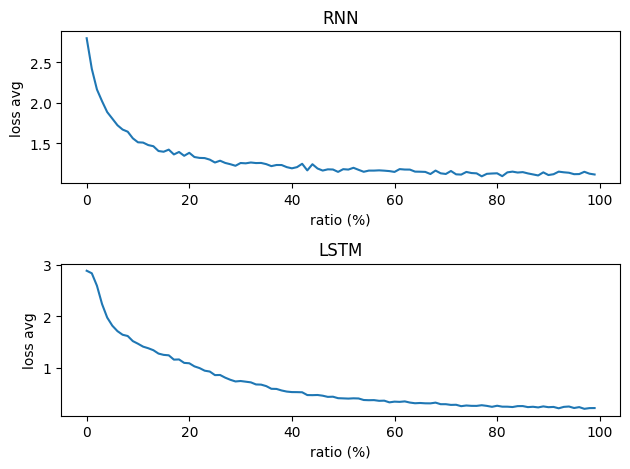

In [31]:
'''result plot (loss record) visualization'''
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import os    
os.environ['KMP_DUPLICATE_LIB_OK']='True'

plt.subplot(2,1,1)
plt.plot(rnn_all_losses)
plt.title('RNN')
plt.ylabel('loss avg')
plt.xlabel('ratio (%)')

plt.subplot(2,1,2)
plt.plot(lstm_all_losses)
plt.title('LSTM')
plt.ylabel('loss avg')
plt.xlabel('ratio (%)')

plt.tight_layout()

In [32]:
'''
Evaluate result (make confusion matrix)

confusion matrix : value of the probabilitythat a row is assumed to be a column
'''
import os    
os.environ['KMP_DUPLICATE_LIB_OK']='True'

confusion_rnn = torch.zeros(names.n_categories, names.n_categories)
confusion_lstm = torch.zeros(names.n_categories, names.n_categories)
n_confusion = 10000


def evaluate_rnn(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output


def evaluate_lstm(line_tensor):
    hidden = lstm.initHidden()
    cell = lstm.initCell()

    for i in range(line_tensor.size()[0]):
        output, hidden, cell = lstm(line_tensor[i], hidden, cell)

    return output


# record answer in confusion matrix
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = names.randomTrainingExample()

    output = evaluate_rnn(line_tensor)
    guess, guess_i = names.categoryFromOutput(output)
    category_i = names.all_categories.index(category)
    confusion_rnn[category_i][guess_i] += 1

    output = evaluate_lstm(line_tensor)
    guess, guess_i = names.categoryFromOutput(output)
    category_i = names.all_categories.index(category)
    confusion_lstm[category_i][guess_i] += 1


# normalization
for i in range(names.n_categories):
    confusion_rnn[i] = confusion_rnn[i] / confusion_rnn[i].sum()
    confusion_lstm[i] = confusion_lstm[i] / confusion_lstm[i].sum()

C:\Users\wpffl\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  import sys
C:\Users\wpffl\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  


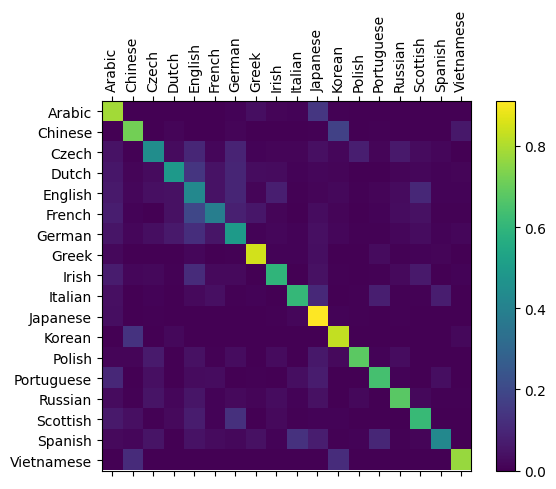

In [33]:
# visulaization RNN
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion_rnn.numpy())
fig.colorbar(cax)

ax.set_xticklabels([''] + names.all_categories, rotation=90)
ax.set_yticklabels([''] + names.all_categories)

ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show()

C:\Users\wpffl\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  import sys
C:\Users\wpffl\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  


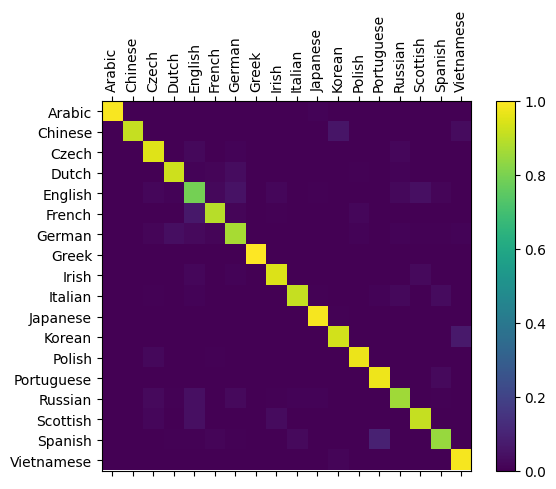

In [34]:
# visulaization LSTM
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion_lstm.numpy())
fig.colorbar(cax)

ax.set_xticklabels([''] + names.all_categories, rotation=90)
ax.set_yticklabels([''] + names.all_categories)

ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show()